In [1]:
# Installing Pillow Libraries
!pip install scikit-learn matplotlib Pillow

In [24]:
import numpy as np
import os
import pandas as pd
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA

In [106]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}


In [107]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y]
            image_list.append(im)
            y_list.append(y)
        else:
            continue
        
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [108]:
dirpath = 'data/IIIT-CFW/'
X,y = load_data(dirpath)
type(X)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


numpy.ndarray

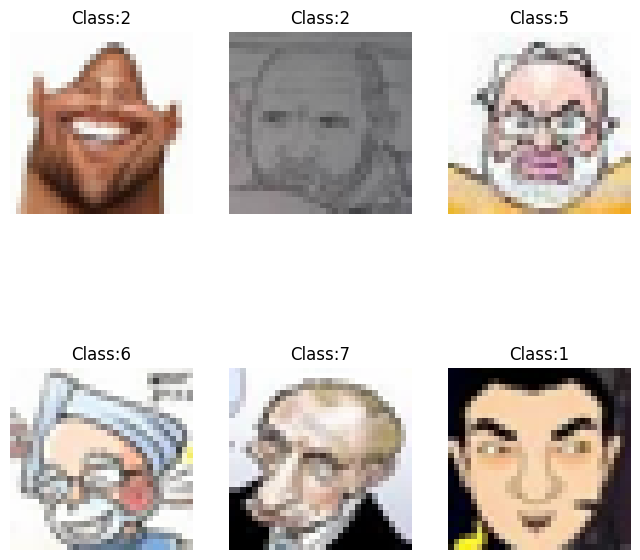

In [109]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

In [184]:
# X_shape = X.reshape((N, H * W * C))   #X is data matrix
X_reshape=np.reshape(X,(N, H * W * C))
print('Reshaped matrix: {}'.format(X_reshape.shape))

Reshaped matrix: (672, 3072)


In [412]:
# write function
def normalization_vector(s,vector):
    for i in range (s):
            vector [:, i] = vector [:, i]/ np.linalg.norm(vector [:, i])
    return vector
def get_eigen(data, y):
    
    #subtracting from mean
    mean=np.mean(data,axis=0)
    data = data - mean
    
    #getting data size and dimension
    no_of_images=data.shape[0]
    dimen=data.shape[1]
    
    #calculating covaiance matrix and eigenvalues
    if no_of_images < dimen:   
        cov = np.dot (data, data.T)  
        eigval ,eigvec = np.linalg.eigh(cov)
        eigvec = np.dot(data.T, eigvec)
        eigvec=normalization_vector(no_of_images,eigvec)
        # for i in range (N):
        #     eigvec [:, i] = eigvec [:, i]/ np.linalg.norm(eigvec [:, i])
        # print('eigenvectors dim:{}'.format(eigenvectors.shape))     (3072, 672)
    #for images less than dimension
    else :   
        cov = np.dot(data.T, data) 
        eigval ,eigvec = np.linalg.eigh(cov)
            
    #sorting the eigen vectors
    index = np.argsort (- eigval )
    eigval = eigval [index]
    eigvec = eigvec [:, index]
    
    return  eigval , eigvec 

eigval , eigvec = get_eigen(X_reshape, y)
eigvec = eigvec.T
print(eigvec.shape) #returning the size of eogenvectors 
print(eigvec[0])
print(eigval[0])

(672, 3072)
[0.02292623 0.02397955 0.02493145 ... 0.02018243 0.02059623 0.02169246]
54037.090920998475


In [250]:
# eigen values and spectrum
np.set_printoptions(suppress=True)

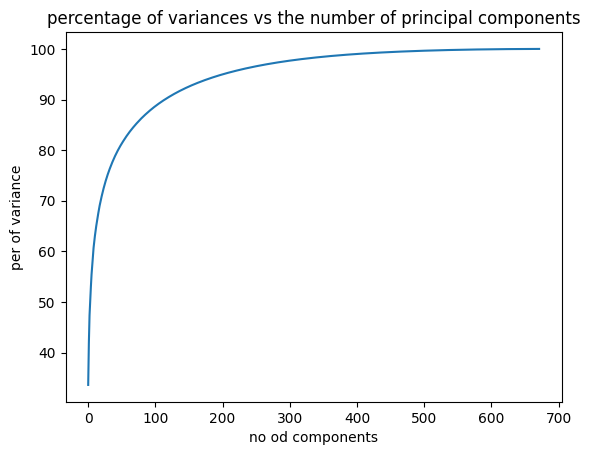

In [415]:
#Plot the percentage of variances vs the number of principal components

step_size=range(0, eigvec.shape[0])

plt.plot(step_size,(np.cumsum(eigval) / np.sum(eigval))*100.0)
plt.title("percentage of variances vs the number of principal components")
plt.xlabel('no od components')
plt.ylabel('per of variance')
plt.show()

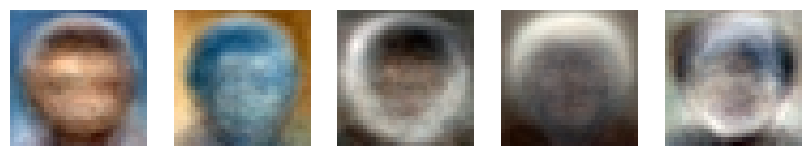

In [419]:

#Use the below sample code to visualize the eigen faces and reconstructed images (can write your own function as well)

def plot(image,H,W,C,indices):
    #indices = [randrange(100)+1 for i in range(5)]
    pl = np.reshape(image,(-1,H,W,C))
    plt.figure(figsize=(25,25))
    for c,i in enumerate(indices):
        ele = pl[i]
        minim = np.min(ele)
        maxim = np.max(ele)
        ele = (ele - minim) / (maxim - minim)
        ele = np.clip(ele,0,254)
        plt.subplot(1,12,c+1)
        plt.axis('off')
        plt.imshow(ele,cmap=plt.cm.gray)
    plt.show()

indices = [randrange(12)+1 for i in range(5)]
plot(eigvec,H,W,C, indices)



In [418]:
def get_eigvec(eigval, variance = .90):
    for ii, eigenvalue_cumulative_sum in enumerate(np.cumsum(eigval) / np.sum(eigval)):
        if eigenvalue_cumulative_sum > variance:
            return ii
        
def reconstruction (eigvec_proj , P , mu) :
    return (eigvec_proj.T @ P).reshape(-1) + mu

def projection (eigvec_proj , X , mu):
    return (eigvec_proj @ (X-mu).reshape(-1, 1))

def Image_plot(img_set, r, c, img_titles):
    fig = plt.figure(figsize = (10, 10))
    count = 0
    for i in range(r):
        for j in range(c):
            if count == len(img_set):
                break
            ax1 = fig.add_subplot(r, c, count + 1)
            ax1.imshow(img_set[count], cmap = 'gray')
            ax1.set_title(img_titles[count], fontsize = 15)
            count = count + 1
    plt.show() 
   




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


number of components required for 90.0 variance: 114
number of components required for 95.0 variance: 201
number of components required for 99.0 variance: 400


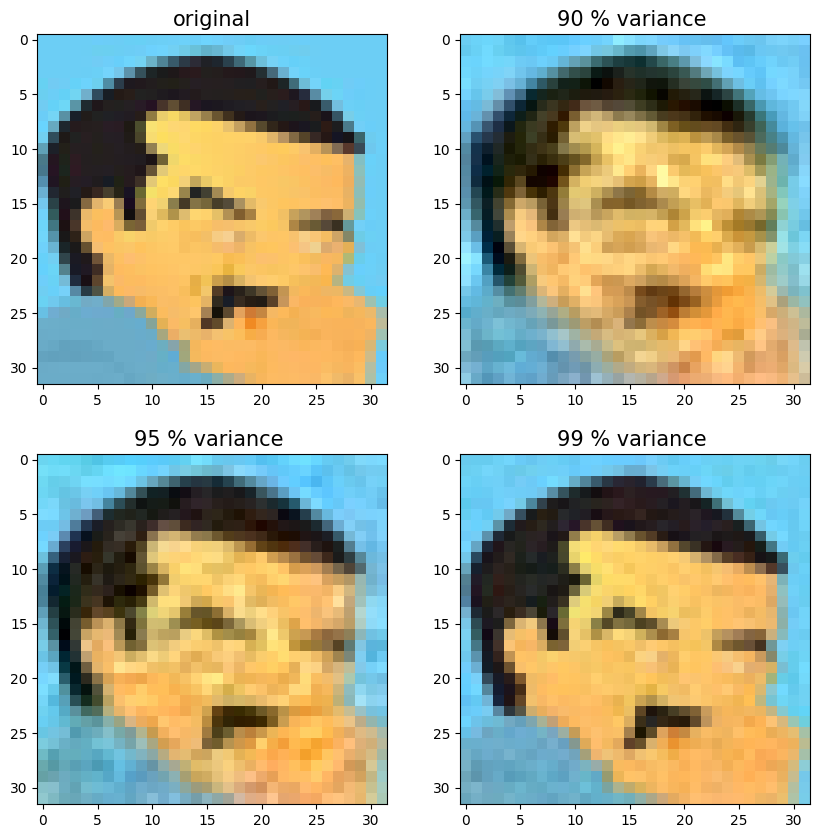

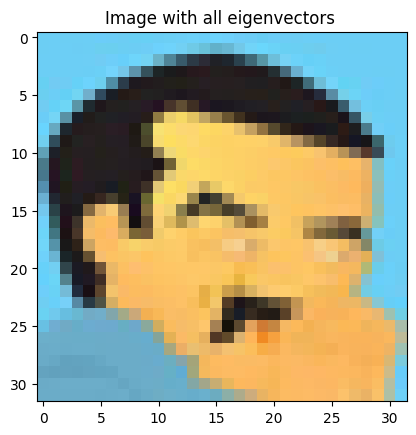

In [289]:
def plot_reconst_var(var,val_eig,eig_vec,mean,H,W,C,image_reshape):
    
    n_comp = get_eigvec(val_eig, var)
    
    print('number of components required for {} variance: {}'.format(var*100.0, n_comp))
    
    Pro = projection(eig_vec[0: n_comp + 1, :], image_reshape.reshape (1 , -1) , mean) 
    Recon = reconstruction(eig_vec[0: n_comp + 1, :], Pro, mean)

    Recon = Recon.reshape(X_reshape[0].shape )
    image.append(Recon.reshape(H,W,C))
    
variance=[0.90,0.95,0.99]

image = []
face = X_reshape[20]
image.append(face.reshape(H,W,C))
mean_image = X_reshape.mean(axis = 0)

for i in variance:
    # print(face.reshape(H,W,C).shape)
    plot_reconst_var(i,eigval,eigvec,mean_image,H,W,C,face)

Image_plot(image, 2, 2, ['original', '90 % variance ', '95 % variance ', '99 % variance '])

#case4 : lets consider all eigenvectors
P = projection(eigvec[0: 672, :], face.reshape (1 , -1) , mean_image)  #these are wts of considered eigenvectors for current face
R = reconstruction(eigvec[0: 672, :], P, mean_image)

R = R.reshape(X_reshape[0].shape )
plt.imshow(R.reshape(H,W,C))

plt.title('Image with all eigenvectors ')
plt.show() 



In [297]:
# Load data again
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


class: Amitabhbachan


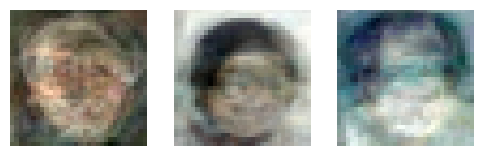

class: AamirKhan


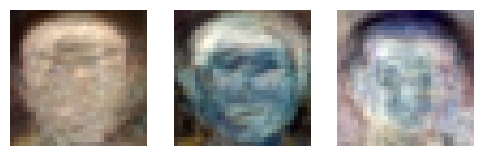

class: DwayneJohnson


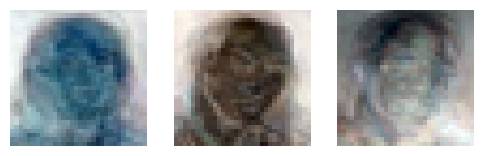

class: AishwaryaRai


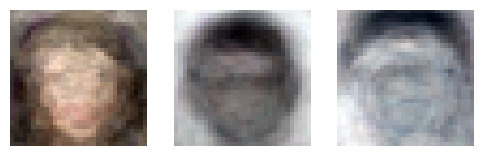

class: BarackObama


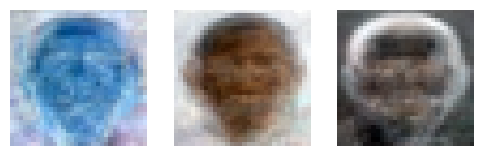

class: NarendraModi


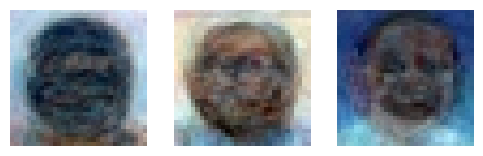

class: ManmohanSingh


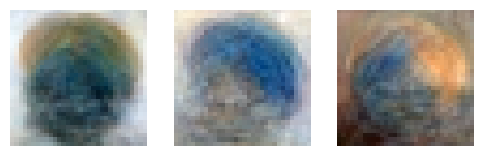

class: VladimirPutin


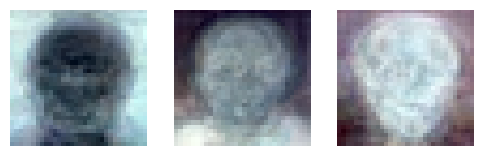

In [340]:
def eigen_plot_class(image,H,W,C,indices):
    pl = np.reshape(image,(-1,H,W,C))
    plt.figure(figsize=(25,25))
    for a,b in enumerate(indices):
        ele = pl[b]
        minimum = np.min(ele)
        maximum = np.max(ele)
        ele = (ele - minimum) / (maximum - minimum)
        ele = np.clip(ele,0,254)
        plt.subplot(1,12,a+1)
        plt.axis('off')
        plt.imshow(ele,cmap=plt.cm.gray)
    plt.show()
    
def eigen_face(key,val,i):
    ind = np.where(y == i)[0]
    class_x = X[ind, :] 
    N,H,W = class_x.shape[0:3]
    
    C = 1 if opt['is_grayscale'] else class_x.shape[3]
    class_x = class_x.reshape((N, H * W * C)) 
    
    eigval, eigvec = get_eigen(class_x, y)
    eigvec = eigvec.T
    
    print('class: {}'.format(key))
    eigen_plot_class(eigvec,H,W,C, range(3))
    
    
i = 0
for keys, vals in cfw_dict.items():
    eigen_face(keys,vals,i)
    i = i + 1

In [342]:
def eigvec_for_given_var(eigval, variance = .90):
    for ii, eigenvalue_cumulative_sum in enumerate(np.cumsum(eigval) / np.sum(eigval)):
        if eigenvalue_cumulative_sum > variance:
            return ii

In [421]:
#For each class
X,y = load_data(dirpath)
var = 0.90

def variability_for_each_class(keys,vals,i):
    print('class: {}'.format(keys))
    ind = np.where(y == i)[0]
    # print(ind)
    class_x = X[ind, :] 
    N,H,W = class_x.shape[0:3]
    
    C = 1 if opt['is_grayscale'] else class_x.shape[3]
    class_x = class_x.reshape((N, H * W * C)) 
    
    eigval, eigvec = get_eigen(class_x, y)
    eigvec = eigvec.T
    
    #step3: Number of principal components required to retain 90% variance
    no_of_components = eigvec_for_given_var(eigval, var)
    print('No of princinpal components required for 90% variance is {}'.format(no_of_components))
    

#for each class
i = 0                               
for keys, vals in cfw_dict.items():
    variability_for_each_class(keys,vals,i)
    i = i + 1
    
#for entire dataset
print('\n')
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N, H * W * C)) 
eigval, eigvec = get_eigen(X, y)
eigvec = eigvec.T
    
no_of_components = eigvec_for_given_var(eigval, variance)
print('No of princinpal components required t 90% variance is {}'.format(no_of_components))



Dataset shape: (672, 32, 32, 3)
Label shape: (672,)
class: Amitabhbachan
No of princinpal components required for 90% variance is 20
class: AamirKhan
No of princinpal components required for 90% variance is 23
class: DwayneJohnson
No of princinpal components required for 90% variance is 27
class: AishwaryaRai
No of princinpal components required for 90% variance is 35
class: BarackObama
No of princinpal components required for 90% variance is 42
class: NarendraModi
No of princinpal components required for 90% variance is 56
class: ManmohanSingh
No of princinpal components required for 90% variance is 49
class: VladimirPutin
No of princinpal components required for 90% variance is 43


No of princinpal components required t 90% variance is 114


In [365]:
# ## Linear Regression (continued)
# 1. Perform linear regression on below datapoints
# 2. Use PCA for dimensionality reduction on this datapoints and then perform Linear regression.
# 3. Perform this experiment on different number of components and report the score for linear regression. Plot the graph of [1-200] principal components vs regression score. What do you observe?

# Note :- Can use inbuilt functions for Linear Regression and PCA for this question

In [379]:
# datapoints
X,_ = load_data(dirpath)
X = X.reshape((X.shape[0],-1))
label = np.array([randrange((32*32*3)) for i in range(5)])
label = np.mean(X[:,label], axis = 1)


Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


0.9769669001329634
0.8088741063667667


Text(0, 0.5, 'score')

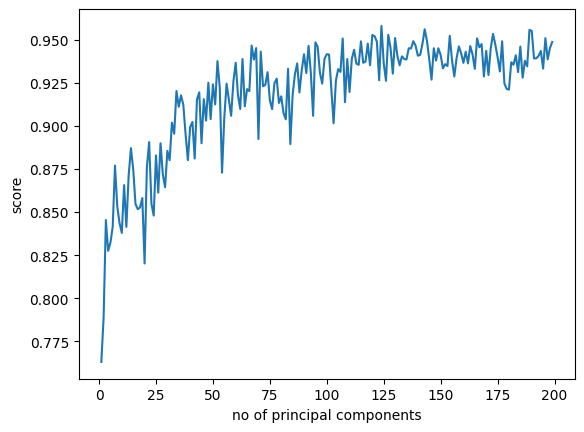

In [411]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, label, test_size = 0.25)

regr = LinearRegression()
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

scale = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(principalComponents, label, test_size = 0.25)

regr = LinearRegression()
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

def compute_pca(n_comp,data,label):
    scale = StandardScaler().fit_transform(data)
    pca = PCA(n_components=n_comp)
    principalComponents = pca.fit_transform(data)
    
    X_train, X_test, y_train, y_test = train_test_split(principalComponents, label, test_size = 0.25)

    regr = LinearRegression()
    regr.fit(X_train, y_train)
    score=regr.score(X_test, y_test)
    
    return score
    
dict={}
n_comp=range(1,200,1)
for i in n_comp:
    Pca=compute_pca(i,X,label)
    dict[i]=Pca

plt.plot(dict.keys(),dict.values())
plt.xlabel('no of principal components')
plt.ylabel('score')

# X_train, X_test, y_train, y_test = train_test_split(principalComponents, label, test_size = 0.25)

# regr = LinearRegression()
# regr.fit(X_train, y_train)
# print(regr.score(X_test, y_test))

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144])

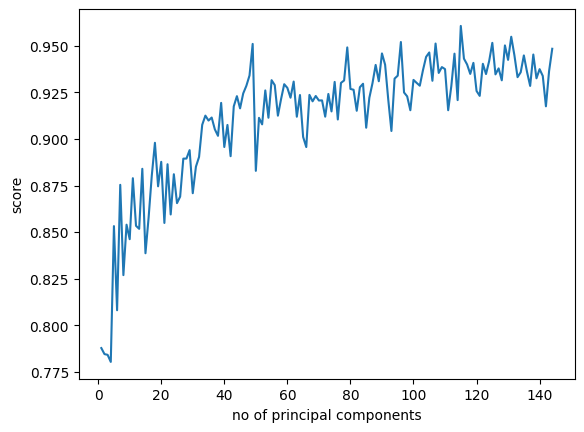

In [410]:
plt.plot(dict.keys(),dict.values())
plt.xlabel('no of principal components')
plt.ylabel('score')


In [311]:
# plot variance vs components
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
temp=scaler.fit_transform(X_shape)

In [95]:
comp=[]
pVar=[]
for i in range(1,200):
    pca=PCA(n_components=i)
    pComp=pca.fit_transform(X_shape)
    comp.append(i)
    pVar.append(round(sum(list(pca.explained_variance_ratio_))*100, 2))

Text(0, 0.5, 'Percentage of variance')

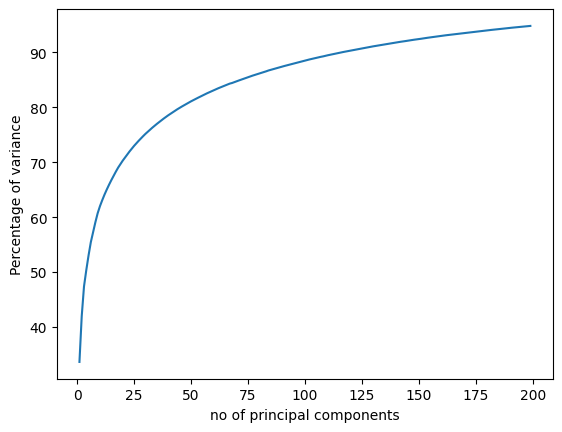

In [96]:
plt.plot(comp,pVar)
plt.xlabel('no of principal components')
plt.ylabel('Percentage of variance')


In [85]:
#calculating eigne values
def eigen(A):
    a=A
    b=A.T
    c=np.dot(a,b)
    return np.linalg.eig(c)

In [81]:
eigval,eigvec=eigen(X_shape)

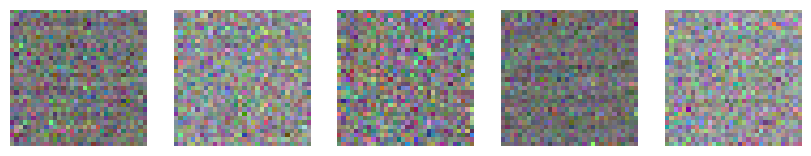